In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math
import pmdarima as pm

import lead_lag as ll

In [2]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
df["time"] = pd.to_datetime([i for i in range(1000)], unit='D', origin=pd.Timestamp('2020-01-01'))
df.set_index("time", inplace=True)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,12.16671,66.190820,46.245800,45.805040,53.434400,9.80468,17.790600,50.959960,68.03811,54.033990,...,30.350180,71.991100,11.406310,57.9546,33.568220,50.340710,67.87408,34.611200,40.585290,54.836260
std,1.99461,4.171327,1.242464,2.816865,2.763579,2.07627,0.661056,5.354948,0.96049,4.836732,...,1.619163,10.570417,1.337563,5.2817,3.634882,2.651905,11.37598,0.808334,4.040864,1.667924
min,8.52000,59.610000,43.810000,41.690000,47.190000,6.38000,16.220000,44.010000,65.64000,45.260000,...,26.720000,50.620000,9.240000,44.3300,26.660000,43.980000,49.20000,32.800000,31.640000,51.500000
25%,10.25000,63.067500,45.530000,43.367500,51.697500,7.80500,17.290000,46.690000,67.55750,49.537500,...,28.840000,64.627500,10.387500,56.9950,29.887500,48.417500,55.42750,34.047500,37.377500,53.465000
50%,12.94000,64.905000,46.445000,45.550000,53.480000,9.99000,17.970000,48.610000,68.19000,54.515000,...,30.715000,74.905000,11.140000,59.6750,33.945000,50.715000,65.76000,34.615000,40.990000,54.640000
75%,13.59000,68.292500,46.972500,47.830000,55.875000,11.85000,18.340000,55.660000,68.73000,57.995000,...,31.590000,80.970000,12.210000,61.4225,36.822500,52.372500,79.56500,35.162500,43.822500,56.110000
max,15.56000,75.150000,48.610000,51.010000,59.120000,13.00000,18.980000,63.330000,69.99000,63.520000,...,33.260000,88.000000,14.500000,66.0900,39.130000,54.150000,86.42000,36.480000,50.020000,59.310000


In [3]:
# Check if stationary
# Non-stationary
def test_stationary(series):
    print("Results of Dickey-Fuller Test:")
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    print("Results of KPSS Test:")
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

test_stationary(df["8"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.227240
p-value                          0.196508
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64
Results of KPSS Test:
Test Statistic            2.403028
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_5012\2492717299.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")


In [4]:
from datetime import datetime, timedelta

train = df.iloc[:750, :]
train.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(train.shape[0])]
mvgTrain = train[:].rolling(5).mean()

test = df.iloc[750:, :]
test.index = index=[datetime(2022, 1, 1, 12, 0, 0) - timedelta(seconds=i) for i in range(test.shape[0])]
mvgTest = test[:].rolling(5).mean()

0.9881772796362251
0.6048711914568213


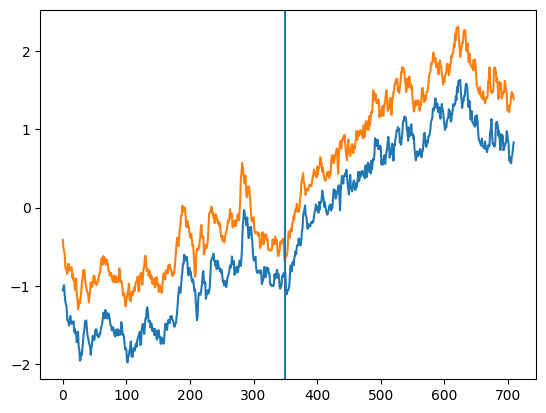

In [5]:
# Check for lead lags
# (18, 3): Not accurate enough
share1 = "36"
share2 = "7"
lag = 290

standard1 = (df[share1] - df[share1].mean())/df[share1].std()
standard2 = (df[share2] - df[share2].mean())/df[share2].std()
shifted1 = pd.Series(np.array(standard1)[:-lag])
shifted2 = pd.Series(np.array(standard2)[lag:])

print(shifted1.corr(shifted2))
print(df[share1].corr(df[share2]))

sns.lineplot(shifted1)
sns.lineplot(shifted2)
plt.axvline(350)


In [10]:
# results = {}
# for i in range(50):
#     for j in range(i+1, 50):
#         t1, t2 = str(i), str(j)
#         lag = ll.lag(mvgTrain[t1], mvgTrain[t2], max_lag=300)
#         lag = int(lag)
#         # test for cointegration
#         if lag > 0:
#             # t1 leads t2, shift t1 forward

#             pass
#         elif lag < 0:
#             # other way
#             t1, t2 = t2, t1
#             lag = -lag
#         else:
#             continue

#         shiftt1 = train[t1][lag:]
#         shiftt2 = train[t2][:-lag]
#         res = sm.tsa.stattools.coint(shiftt1, shiftt2)
#         corr = shiftt1.corr(shiftt2)
#         results[t1,t2] = (res[1], corr, lag)


In [57]:
# Predict function for lead lag
def predict_next(df, ticker, indices, lags, currentPoint):
    matchedSeries = df[indices].pct_change().dropna().values
    # matchedSeries = df[indices]
    if len(indices) > 1:
        matchedSeries = matchedSeries[currentPoint-599:currentPoint+1, :]
    else:
        matchedSeries = matchedSeries[currentPoint-599:currentPoint+1]
    
    predictSeries = df[ticker].pct_change().dropna().values[currentPoint-599:currentPoint+1]
    # predictSeries = df[ticker].values[currentPoint-199:currentPoint+1]
    # print(matchedSeries.shape)
    # print(len(predictSeries))

    result = ardl.ARDL(
        predictSeries,
        0,
        matchedSeries,
        lags,
        causal=True
    ).fit()

    predict_val = result.forecast()
    # print(result.summary())
    return predict_val

In [ ]:
# # Predict function for lead lag with moving average
# def predict_next_mvg(df, ticker, indices, lags, shift, currentPoint):
#     matchedSeries = df[indices].rolling(5).mean().dropna().values
#     if len(indices) > 1:
#         matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1, :]
#     else:
#         matchedSeries = matchedSeries[currentPoint-shift-199:currentPoint-shift+1]
    
#     predictSeries = df[ticker].rolling(5).mean().dropna().values[currentPoint-199:currentPoint+1]
#     # print(matchedSeries.shape)
#     # print(len(predictSeries))

#     result = ardl.ARDL(
#         predictSeries,
#         0,
#         matchedSeries,
#         lags,
#         causal=True
#     ).fit()

#     predict_val = result.forecast()
#     # print(predict_mu)
#     return predict_val

59.23375 1.6753717485834052
-0.0012068282276027345 0.04206639601627039
0.010766129032258072 0.4651827138111212
MSE error 0.005802293657190205


(0     -0.038253
 1     -0.052584
 2      0.053824
 3     -0.004111
 4      0.007341
          ...   
 243    0.010941
 244    0.029271
 245    0.004393
 246    0.016583
 247    0.005802
 Length: 248, dtype: float64,
 0      0.50
 1     -0.60
 2      0.58
 3     -0.34
 4      0.30
        ... 
 243    0.49
 244    0.32
 245   -0.22
 246    0.07
 247   -0.34
 Length: 248, dtype: float64)

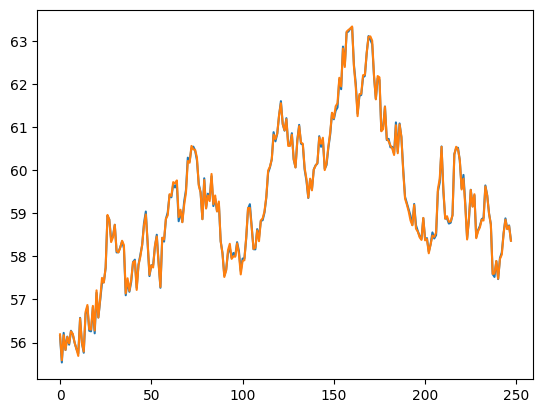

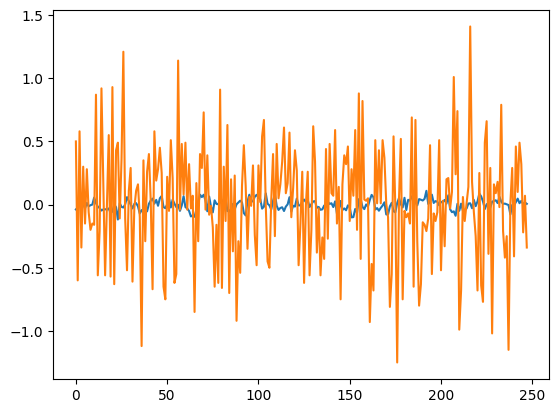

In [49]:
def test_error(sharePredict, indices, lags, printing=False):
    predictValues = []
    errors = []
    actuals = []

    actual_changes = []
    predict_changes = []

    for i in range(751, 999):
        actual_values = df[sharePredict].values

        # For pct_change
        predict_change = predict_next(df, sharePredict, indices, lags, i-1)[-1]
        predict = actual_values[i] * (1 + predict_change)

        # predict = predict_next(df, sharePredict, indices, lags, shift, i)[-1]
        

        actual = actual_values[i+1]
        error = predict - actual

        errors.append(error)
        actuals.append(actual)
        predictValues.append(predict)
        actual_changes.append(actual - actual_values[i])
        predict_changes.append(predict - actual_values[i])

    actuals = pd.Series(actuals)
    errors = pd.Series(errors)
    actual_changes = pd.Series(actual_changes)

    if printing:
        print(actuals.mean(), actuals.std())
        print(errors.mean(), errors.std())
        print(actual_changes.mean(), actual_changes.std())
        print("MSE error", math.sqrt((error * error).mean()))


        sns.lineplot(predictValues)
        sns.lineplot(actuals)

        plt.figure()
        plt.plot(errors)
        plt.plot(actual_changes)

    return(errors, actual_changes)

test_error("7", ["36"], [286, 287, 288], printing=True)

In [ ]:
# Terry: Method to dig out the shift

# def multiply(a, b):
#     return np.sum(a*b)


# def shift_plot(t1, t2, most):
#     xs = np.arange(most)
#     ys = np.zeros(most)

#     for i in range(most):
#         ys[i] = multiply(df[t1].pct_change(), df[t2].pct_change().shift(i))

#     return xs, ys

# def find_outlier(t1, t2, most):
#     xs, ys = shift_plot(t1, t2, most)
#     m, sd = np.mean(ys), np.std(ys)

#     output = []

#     z = (ys-m) / sd
#     for i in range(most):
#         if z[i] > 10:
#             output.append((t1, t2, i))
    
#     return output

# for t1 in range(50):
#     for t2 in range(50):
#         if t1 == t2:
#             continue

#         output = find_outlier(str(t1), str(t2), 700)
#         if len(output) > 0:
#             print(output)



In [61]:
lags = '''
[('0', '8', 573)]
[('0', '29', 287)]
[('1', '9', 573)]
[('1', '30', 287)]
[('2', '10', 573)]
[('2', '31', 287)]
[('3', '11', 573)]
[('3', '32', 287)]
[('4', '12', 573)]
[('4', '33', 287)]
[('5', '13', 573)]
[('5', '34', 287)]
[('6', '14', 573)]
[('6', '35', 287)]
[('7', '15', 573)]
[('7', '36', 287)]
[('8', '16', 573)]
[('8', '27', 0)]
[('8', '37', 287)]
[('8', '38', 0)]
[('9', '17', 573)]
[('9', '38', 287)]
[('10', '18', 573)]
[('10', '39', 287)]
[('11', '19', 573)]
[('11', '40', 287)]
[('12', '20', 573)]
[('12', '38', 0)]
[('12', '41', 287)]
[('13', '21', 573)]
[('13', '42', 287)]
[('14', '22', 573)]
[('14', '43', 287)]
[('15', '23', 573)]
[('15', '44', 287)]
[('16', '24', 573)]
[('16', '27', 0)]
[('16', '38', 0)]
[('16', '39', 0)]
[('16', '45', 287)]
[('17', '25', 573)]
[('17', '46', 287)]
[('18', '26', 573)]
[('18', '47', 287)]
[('19', '48', 287)]
[('20', '28', 573)]
[('20', '49', 287)]
[('21', '0', 286)]
[('21', '29', 573)]
[('22', '1', 286)]
[('22', '30', 573)]
[('23', '2', 286)]
[('23', '31', 573)]
[('24', '3', 286)]
[('24', '32', 573)]
[('25', '4', 286)]
[('25', '33', 573)]
[('26', '5', 286)]
[('26', '34', 573)]
[('27', '6', 286)]
[('27', '8', 0)]
[('27', '12', 0)]
[('27', '16', 0)]
[('27', '38', 0)]
[('27', '39', 0)]
[('28', '7', 286)]
[('28', '27', 0)]
[('28', '36', 573)]
[('28', '38', 0)]
[('29', '8', 286)]
[('29', '37', 573)]
[('29', '38', 0)]
[('30', '9', 286)]
[('31', '10', 286)]
[('31', '39', 573)]
[('32', '11', 286)]
[('32', '40', 573)]
[('33', '12', 286)]
[('33', '41', 573)]
[('34', '13', 286)]
[('34', '42', 573)]
[('35', '14', 286)]
[('35', '43', 573)]
[('36', '15', 286)]
[('36', '44', 573)]
[('37', '16', 286)]
[('37', '45', 573)]
[('38', '8', 0)]
[('38', '12', 0)]
[('38', '16', 0)]
[('38', '17', 286)]
[('38', '22', 1)]
[('38', '27', 0)]
[('38', '28', 0)]
[('38', '29', 0)]
[('38', '30', 1)]
[('38', '39', 0)]
[('39', '18', 286)]
[('39', '27', 0)]
[('39', '38', 0)]
[('39', '47', 573)]
[('40', '19', 286)]
[('40', '48', 573)]
[('41', '20', 286)]
[('41', '49', 573)]
[('42', '0', 572)]
[('42', '21', 286)]
[('43', '1', 572)]
[('43', '22', 286)]
[('44', '2', 572)]
[('44', '23', 286)]
[('45', '3', 572)]
[('45', '24', 286)]
[('46', '4', 572)]
[('46', '25', 286)]
[('47', '5', 572)]
[('47', '26', 286)]
[('48', '6', 572)]
[('48', '27', 286)]
[('49', '7', 572)]
[('49', '28', 286)]
 '''

newLags = "[" + lags.replace("]\n", "], ").replace("\n", "") + "]"
newLags

"[[('0', '8', 573)], [('0', '29', 287)], [('1', '9', 573)], [('1', '30', 287)], [('2', '10', 573)], [('2', '31', 287)], [('3', '11', 573)], [('3', '32', 287)], [('4', '12', 573)], [('4', '33', 287)], [('5', '13', 573)], [('5', '34', 287)], [('6', '14', 573)], [('6', '35', 287)], [('7', '15', 573)], [('7', '36', 287)], [('8', '16', 573)], [('8', '27', 0)], [('8', '37', 287)], [('8', '38', 0)], [('9', '17', 573)], [('9', '38', 287)], [('10', '18', 573)], [('10', '39', 287)], [('11', '19', 573)], [('11', '40', 287)], [('12', '20', 573)], [('12', '38', 0)], [('12', '41', 287)], [('13', '21', 573)], [('13', '42', 287)], [('14', '22', 573)], [('14', '43', 287)], [('15', '23', 573)], [('15', '44', 287)], [('16', '24', 573)], [('16', '27', 0)], [('16', '38', 0)], [('16', '39', 0)], [('16', '45', 287)], [('17', '25', 573)], [('17', '46', 287)], [('18', '26', 573)], [('18', '47', 287)], [('19', '48', 287)], [('20', '28', 573)], [('20', '49', 287)], [('21', '0', 286)], [('21', '29', 573)], [('22'

In [58]:
def getRange(midVal: int):
    if midVal >= 1:
        return (midVal-1, midVal, midVal+1)
    return (midVal+1, midVal + 2, midVal + 3)

In [59]:
testLags = [[('0', '8', 573)], [('0', '29', 287)], [('1', '9', 573)], [('1', '30', 287)], [('2', '10', 573)], [('2', '31', 287)], [('3', '11', 573)], [('3', '32', 287)], [('4', '12', 573)], [('4', '33', 287)], [('5', '13', 573)], [('5', '34', 287)], [('6', '14', 573)], [('6', '35', 287)], [('7', '15', 573)], [('7', '36', 287)], [('8', '16', 573)], [('8', '27', 0)], [('8', '37', 287)], [('8', '38', 0)], [('9', '17', 573)], [('9', '38', 287)], [('10', '18', 573)], [('10', '39', 287)], [('11', '19', 573)], [('11', '40', 287)], [('12', '20', 573)], [('12', '38', 0)], [('12', '41', 287)], [('13', '21', 573)], [('13', '42', 287)], [('14', '22', 573)], [('14', '43', 287)], [('15', '23', 573)], [('15', '44', 287)], [('16', '24', 573)], [('16', '27', 0)], [('16', '38', 0)], [('16', '39', 0)], [('16', '45', 287)], [('17', '25', 573)], [('17', '46', 287)], [('18', '26', 573)], [('18', '47', 287)], [('19', '48', 287)], [('20', '28', 573)], [('20', '49', 287)], [('21', '0', 286)], [('21', '29', 573)], [('22', '1', 286)], [('22', '30', 573)], [('23', '2', 286)], [('23', '31', 573)], [('24', '3', 286)], [('24', '32', 573)], [('25', '4', 286)], [('25', '33', 573)], [('26', '5', 286)], [('26', '34', 573)], [('27', '6', 286)], [('27', '8', 0)], [('27', '12', 0)], [('27', '16', 0)], [('27', '38', 0)], [('27', '39', 0)], [('28', '7', 286)], [('28', '27', 0)], [('28', '36', 573)], [('28', '38', 0)], [('29', '8', 286)], [('29', '37', 573)], [('29', '38', 0)], [('30', '9', 286)], [('31', '10', 286)], [('31', '39', 573)], [('32', '11', 286)], [('32', '40', 573)], [('33', '12', 286)], [('33', '41', 573)], [('34', '13', 286)], [('34', '42', 573)], [('35', '14', 286)], [('35', '43', 573)], [('36', '15', 286)], [('36', '44', 573)], [('37', '16', 286)], [('37', '45', 573)], [('38', '8', 0)], [('38', '12', 0)], [('38', '16', 0)], [('38', '17', 286)], [('38', '22', 1)], [('38', '27', 0)], [('38', '28', 0)], [('38', '29', 0)], [('38', '30', 1)], [('38', '39', 0)], [('39', '18', 286)], [('39', '27', 0)], [('39', '38', 0)], [('39', '47', 573)], [('40', '19', 286)], [('40', '48', 573)], [('41', '20', 286)], [('41', '49', 573)], [('42', '0', 572)], [('42', '21', 286)], [('43', '1', 572)], [('43', '22', 286)], [('44', '2', 572)], [('44', '23', 286)], [('45', '3', 572)], [('45', '24', 286)], [('46', '4', 572)], [('46', '25', 286)], [('47', '5', 572)], [('47', '26', 286)], [('48', '6', 572)], [('48', '27', 286)], [('49', '7', 572)], [('49', '28', 286)]]

result = {}
validLags = []
for lag in testLags:
    print(lag)
    lag = lag[0]
    errors, actual_changes = test_error(lag[0], [lag[1]], getRange(lag[2]))

    testRatio = actual_changes.std()/errors.std()
    result[lag] = testRatio
    print(testRatio)
    if testRatio > 8:
        validLags.append(lag)
        print(validLags)

validLags


[('0', '8', 573)]
2.1728764007603396
[('0', '29', 287)]
3.2991352333203525
[('1', '9', 573)]
8.81298964630378
[('1', '9', 573)]
[('1', '30', 287)]
8.76437526900332
[('1', '9', 573), ('1', '30', 287)]
[('2', '10', 573)]
2.5702578073767586
[('2', '31', 287)]
2.872812867421398
[('3', '11', 573)]
11.356881468630151
[('1', '9', 573), ('1', '30', 287), ('3', '11', 573)]
[('3', '32', 287)]
6.163026317000169
[('4', '12', 573)]
2.648424716137107
[('4', '33', 287)]
7.449313423396513
[('5', '13', 573)]
